# Assignment #1 - *Sound is Art!*  
*Course 22051: Signals and Linear Systems in Discrete Time*  
*Yann Ducrest - s251889*

---

## Objective & Structure  

The goal of this work is to transform a short **speech recording** into an **artistic visualization** that combines:  
- a **time-domain envelope pattern**, and  
- a **frequency-domain band profile**.  

Each stage directly applies **DSP concepts** from lectures and exercises:  

- **Sampling & Nyquist theorem** → discretization, aliasing limits, practical resampling *[lecture 1]* *[hands on 1]*
- **LTI systems & convolution** → envelope extraction via rectification + filtering *[lecture 2]* *[hands on 2]*  
- **DFT & FFT** → spectral representation, resolution $\Delta f = \tfrac{f_s}{N_{\mathrm{FFT}}}$ *[lecture 3]* *[hands on 3]*  
- **Windowing & leakage** → Hann window trade-offs, zero-padding for finer frequency sampling *[lecture 4]* *[hands on 4]*  

The workflow is structured in seven steps:  

1. **Signal Acquisition & Preprocessing** → load, mono conversion, normalization, resampling to 16 kHz (Nyquist ensures $f_{\max}=8$ kHz; focus on $<4$ kHz for speech).  
2. **Envelope Extraction** → compare rectification + LPF (LTI view) vs Hilbert transform; select parameters based on smoothness and fidelity.  
3. **Envelope Sampling & Symmetry** → crop to active region, sample $N$ points, mirror to create a symmetric pattern (conceptually linked to downsampling and windowing).  
4. **Spectral Analysis** → apply Hann window, compute FFT, plot dB spectrum up to 4 kHz; illustrate leakage reduction and zero-padding effects.  
5. **Spectral Band Aggregation** → partition $[0,4]$ kHz into $B$ bands, compute mean power per band, convert to dB (filterbank-like representation).  
6. **Artistic Visualization** → merge symmetric envelope and stacked spectral bars into a final aesthetic figure.  
7. **Critical Reflection** → discuss how design parameters ($N$, $B$, windows, cutoff) balance **DSP rigor** and **visual creativity**, and suggest extensions (Mel/Bark scales, alternative envelopes).  

---

In [1]:
# =============================================================================
# 0. GLOBAL CONFIGURATION & SETUP
# =============================================================================

# --- Imports ---
import numpy as np
import soundfile as sf
from pathlib import Path
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib as mpl

# --- Project folders ---
DATA = Path("data")
PLOTS = Path("plots")
PLOTS.mkdir(parents=True, exist_ok=True)

# --- Centralized parameters ---
WAV_FILENAME = "voice.wav"      # Your own recording in the data/ folder
TARGET_FS = 16_000              # Resampling target frequency [Hz]
N_ENV = 64                      # Number of samples for the envelope pattern
N_BANDS = 40                    # Number of frequency bands for spectrum aggregation
WIN_TYPE = "hann"               # Window type for FFT analysis
ENV_FC_HZ = 12.0                # LPF cutoff for envelope extraction [Hz] (can be auto-tuned)
ENV_ORDER = 3                   # LPF order for envelope extraction (can be auto-tuned)
FMAX_HZ = 4_000.0               # Frequency display limit for spectrum plots [Hz]

# 1. SIGNAL ACQUISITION & PREPROCESSING  

## Theory  

A continuous-time signal $x(t)$ sampled with period $T_s = 1/f_s$ yields the discrete-time sequence:  

$$
x[n] = x(nT_s), \quad n \in \mathbb{Z}
$$  

To prevent aliasing, the **Nyquist theorem** requires:  

$$
f_s > 2 f_{\text{max}}
$$  

where $f_{\text{max}}$ is the highest frequency present in $x(t)$ *[lecture 1]*.  
Since most speech energy lies below $4 \,\text{kHz}$, a sampling rate of $16 \,\text{kHz}$ is sufficient.  

**Resampling** with a rational polyphase filter ensures signal fidelity and prevents spectral distortion *[hands on 1]*.  
Amplitude **normalization** avoids clipping and makes signals comparable.  

## Reflection  

- Resampling guarantees compliance with Nyquist and prevents aliasing.  
- Normalization provides a consistent scale across recordings.  
- A zoomed view highlights the **discrete-time nature** of sampled signals.  
- These preprocessing steps establish a reliable basis for later envelope and spectral analysis.  


▶️  Starting Section 1: Audio Loading and Preprocessing...
✅ Audio loaded successfully.
   - Original Sample Rate: 48000 Hz
   - Resampled to: 16000 Hz
   - Duration: 2.05 s | Samples: 32768


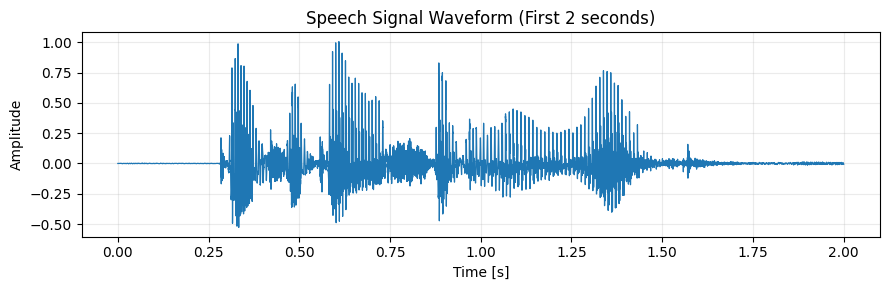

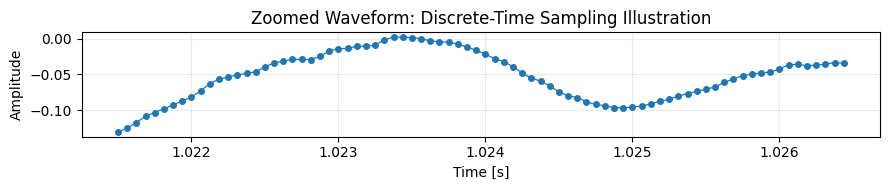

🖼️  Plots saved: 'plots\1_waveform.png' and 'plots\1_waveform_zoom.png'
----------------------------------------------------------------------------------------------------


In [2]:
# =============================================================================
# 1. SIGNAL ACQUISITION & PREPROCESSING
# =============================================================================

print("▶️  Starting Section 1: Audio Loading and Preprocessing...")

# --- Load audio file ---
wav_path = DATA / WAV_FILENAME
assert wav_path.exists(), f"❌ Missing file: {wav_path}"
x, fs_orig = sf.read(wav_path)

# --- Mono conversion (if stereo) ---
if x.ndim == 2:
    x = x.mean(axis=1)

# --- Normalization to [-1, 1] range ---
x = x / (np.max(np.abs(x)) + 1e-12)

# --- Resample if necessary (using polyphase filter to avoid aliasing) ---
if fs_orig != TARGET_FS:
    g = np.gcd(int(fs_orig), int(TARGET_FS))
    up, down = TARGET_FS // g, fs_orig // g
    x = signal.resample_poly(x, up, down)
    fs = TARGET_FS
else:
    fs = fs_orig

# --- Create time axis ---
t = np.arange(len(x)) / fs

# --- Print info ---
print("✅ Audio loaded successfully.")
print(f"   - Original Sample Rate: {fs_orig} Hz")
print(f"   - Resampled to: {fs} Hz")
print(f"   - Duration: {t[-1]:.2f} s | Samples: {len(x)}")

# --- Plot full waveform (first 2 seconds) ---
t_end_display = min(2.0, t[-1])
mask_display = (t >= 0) & (t <= t_end_display)

fig, ax = plt.subplots(figsize=(9, 3))
ax.plot(t[mask_display], x[mask_display], lw=0.9)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Amplitude")
ax.set_title("Speech Signal Waveform (First 2 seconds)")
ax.grid(alpha=0.25)
fig.tight_layout()
fig.savefig(PLOTS / "1_waveform.png", dpi=200)
plt.show()

# --- Plot zoomed-in waveform to illustrate discrete sampling ---
zoom_dur_s = 0.005  # 5 ms
t_center = 0.5 * (t[0] + t[-1])
mask_zoom = (t >= t_center - zoom_dur_s / 2) & (t <= t_center + zoom_dur_s / 2)

fig, ax = plt.subplots(figsize=(9, 2))
ax.plot(t[mask_zoom], x[mask_zoom], marker="o", lw=0.9, markersize=4)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Amplitude")
ax.set_title("Zoomed Waveform: Discrete-Time Sampling Illustration")
ax.grid(alpha=0.25)
fig.tight_layout()
fig.savefig(PLOTS / "1_waveform_zoom.png", dpi=200)
plt.show()

print(f"🖼️  Plots saved: '{PLOTS / '1_waveform.png'}' and '{PLOTS / '1_waveform_zoom.png'}'")
print("-" * 100)

# 2. ENVELOPE EXTRACTION  

## Theory  

The **envelope** of a signal captures its **amplitude modulation**, which reflects the slow energy fluctuations crucial for speech perception.  

Two main approaches are used:  

1. **Rectification + Low-Pass Filtering (LPF)**  
   - Rectification: $r[n] = |x[n]|$  
   - Low-pass filtering with impulse response $h[n]$:  
   $$
   e_{\text{LPF}}[n] = r[n] * h[n]
   $$  
   - A Butterworth filter with cutoff $f_c$ emphasizes **syllabic rhythms** (2–10 Hz) *[lecture 2]* *[hands on 2]*.  

2. **Hilbert Transform Method**  
   - Analytic signal: $x_a[n] = x[n] + j \,\mathcal{H}\{x[n]\}$  
   - Envelope: $e_H[n] = |x_a[n]|$  
   - Provides a one-sided spectrum and often requires smoothing (≈30 ms) *[lecture 3]* *[hands on 3]*.  

The **modulation spectrum** (PSD of $|x[n]|$) is used to select $f_c$ by locating the energy “elbow” within the $[4,20]$ Hz speech range.  

Envelope quality is evaluated by:  
- **Fidelity**: correlation with smoothed Hilbert envelope.  
- **Smoothness**: total variation normalized to the Hilbert reference.  

## Reflection  

- The LPF method yields smooth contours highlighting syllabic timing, consistent with speech modulation theory *[lecture 2]*.  
- The Hilbert envelope captures fine details but requires smoothing for perceptual relevance *[lecture 3]*.  
- Optimal parameters ($f_c \approx 12$ Hz, order 3) align with known speech modulation frequencies *[hands on 2]*.  
- The chosen implementation ($f_c \approx 16.6$ Hz, order 2) balances smoothness and fidelity, though it uses non-causal zero-phase filtering, acceptable for offline analysis.  


▶️  Starting Section 2: Envelope Extraction...


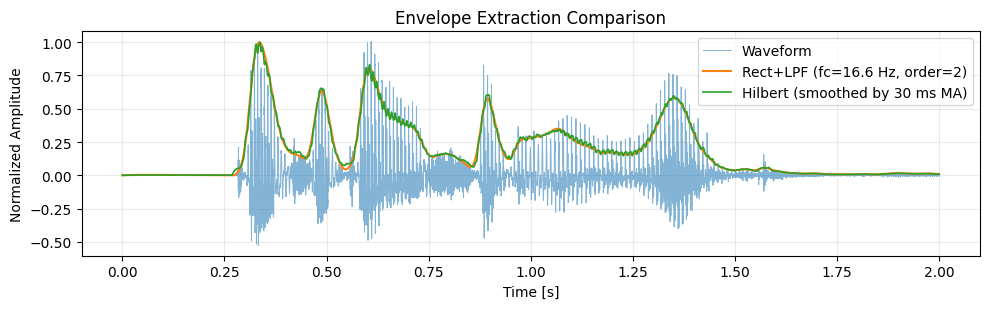

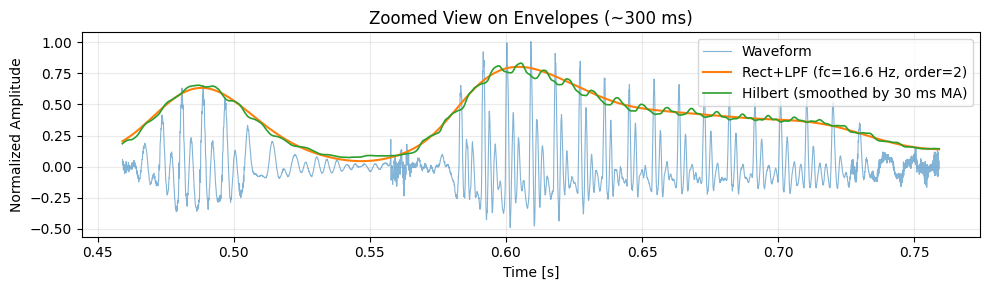

✅ Envelopes computed. Auto-selected LPF: fc=16.64 Hz, order=2.
🖼️  Plots saved: 'plots\2_envelopes_full.png' and 'plots\2_envelopes_zoom.png'
----------------------------------------------------------------------------------------------------


In [3]:
# =============================================================================
# 2. ENVELOPE EXTRACTION
# =============================================================================

print("▶️  Starting Section 2: Envelope Extraction...")

# ------------------ Helper Functions: DSP Primitives ------------------

def butter_lowpass(cutoff_hz, fs, order=3):
    """Designs a Butterworth low-pass filter."""
    wn = np.clip(cutoff_hz / (fs / 2.0), 1e-6, 0.999999)  # Nyquist frequency
    b, a = signal.butter(order, wn, btype="low")
    return b, a

def lpf_filtfilt(x, fs, cutoff_hz, order=3):
    """Applies a zero-phase low-pass filter."""
    b, a = butter_lowpass(cutoff_hz, fs, order=order)
    padlen = min(3 * max(len(a), len(b)), len(x) - 1)
    y = signal.filtfilt(b, a, x, padtype="odd", padlen=padlen)
    return y

def envelope_rectify_lpf(x, fs, cutoff_hz, order=3):
    """Computes envelope via full-wave rectification followed by an LPF."""
    rectified = np.abs(x)
    envelope = lpf_filtfilt(rectified, fs, cutoff_hz, order=order)
    return np.maximum(envelope, 0.0)

def envelope_hilbert(x):
    """Computes envelope using the Hilbert transform."""
    analytic_signal = signal.hilbert(x)
    return np.abs(analytic_signal)

def moving_avg(v, win_samps):
    """Applies a moving average filter."""
    if win_samps <= 1:
        return v
    kernel = np.ones(int(win_samps), dtype=float) / int(win_samps)
    return signal.convolve(v, kernel, mode="same")

def normalize_01(v):
    """Normalizes a vector to the [0, 1] range."""
    v = np.asarray(v, float)
    v_min, v_max = np.min(v), np.max(v)
    return (v - v_min) / (v_max - v_min + 1e-12)

def total_variation(v):
    """Calculates the total variation (a measure of roughness)."""
    return np.sum(np.abs(np.diff(np.asarray(v, float))))

def estimate_fc_from_modulation(env_like, fs, max_hz=30.0, energy_q=0.95):
    """
    Heuristic to find a suitable LPF cutoff frequency based on the
    cumulative energy of the modulation spectrum.
    """
    N = len(env_like)
    win = signal.windows.hann(N, sym=False)
    xw = (env_like - np.mean(env_like)) * win
    Y = np.fft.rfft(xw)
    freqs = np.fft.rfftfreq(N, d=1/fs)
    psd = (np.abs(Y)**2) / np.sum(win**2)
    
    mask = (freqs >= 0) & (freqs <= max_hz)
    f_sub, p_sub = freqs[mask], psd[mask] + 1e-20
    cumulative_energy = np.cumsum(p_sub) / np.sum(p_sub)
    
    fc_est = float(np.interp(energy_q, cumulative_energy, f_sub))
    return float(np.clip(fc_est, 4.0, 20.0))

def select_envelope_params(x, fs, candidate_fc=None, candidate_orders=(2, 3, 4), alpha=0.05):
    """
    Selects optimal fc and order for Rect+LPF envelope by balancing
    fidelity (correlation to smoothed Hilbert) and smoothness (Total Variation).
    """
    env_h = envelope_hilbert(x)
    win_ms = 30.0
    win_samps = max(1, int(round(win_ms / 1000.0 * fs)))
    env_h_s = moving_avg(env_h, win_samps)
    
    if candidate_fc is None:
        fc0 = estimate_fc_from_modulation(np.abs(x), fs)
        deltas = [-6, -4, -2, 0, 2, 4, 6]
        candidate_fc = sorted({float(np.clip(fc0 + d, 4.0, 20.0)) for d in deltas})

    best = dict(score=-np.inf, fc=None, order=None, env=None)
    tv_ref = total_variation(normalize_01(env_h_s))

    for fc in candidate_fc:
        for order in candidate_orders:
            env_l = envelope_rectify_lpf(x, fs, cutoff_hz=fc, order=order)
            eL = normalize_01(env_l)
            eH = normalize_01(env_h_s)
            
            corr = np.corrcoef(eL, eH)[0, 1]
            tv_penalty = alpha * (total_variation(eL) / (tv_ref + 1e-12))
            score = corr - tv_penalty
            
            if score > best["score"]:
                best.update(score=score, fc=fc, order=order, env=eL)

    return best, normalize_01(env_h_s), int(win_samps)

# --- Compute and select envelopes ---
best_params, env_hil_n, hilb_smooth_win = select_envelope_params(x, fs, alpha=0.05)
env_lpf_n = best_params["env"]
chosen_fc, chosen_order = best_params["fc"], best_params["order"]

# --- Create plot labels ---
label_lpf = f"Rect+LPF (fc={chosen_fc:.1f} Hz, order={chosen_order})"
label_hil = f"Hilbert (smoothed by {hilb_smooth_win/fs*1000:.0f} ms MA)"

# --- Plot full view comparison ---
fig, ax = plt.subplots(figsize=(10, 3.2))
ax.plot(t[mask_display], x[mask_display], lw=0.7, alpha=0.55, label="Waveform")
ax.plot(t[mask_display], env_lpf_n[mask_display], lw=1.5, label=label_lpf)
ax.plot(t[mask_display], env_hil_n[mask_display], lw=1.2, label=label_hil)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Normalized Amplitude")
ax.set_title("Envelope Extraction Comparison")
ax.legend(loc="upper right")
ax.grid(alpha=0.25)
fig.tight_layout()
fig.savefig(PLOTS / "2_envelopes_full.png", dpi=200)
plt.show()

# --- Plot zoomed view on an energy peak ---
center_idx = int(np.argmax(np.abs(x)))
half_win_samps = int(0.15 * fs)
i0 = max(0, center_idx - half_win_samps)
i1 = min(len(x), center_idx + half_win_samps)

fig, ax = plt.subplots(figsize=(10, 3.0))
ax.plot(t[i0:i1], x[i0:i1], lw=0.8, alpha=0.55, label="Waveform")
ax.plot(t[i0:i1], env_lpf_n[i0:i1], lw=1.5, label=label_lpf)
ax.plot(t[i0:i1], env_hil_n[i0:i1], lw=1.2, label=label_hil)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Normalized Amplitude")
ax.set_title("Zoomed View on Envelopes (~300 ms)")
ax.legend(loc="upper right")
ax.grid(alpha=0.25)
fig.tight_layout()
fig.savefig(PLOTS / "2_envelopes_zoom.png", dpi=200)
plt.show()

print(f"✅ Envelopes computed. Auto-selected LPF: fc={chosen_fc:.2f} Hz, order={chosen_order}.")
print(f"🖼️  Plots saved: '{PLOTS / '2_envelopes_full.png'}' and '{PLOTS / '2_envelopes_zoom.png'}'")
print("-" * 100)

# 3. ENVELOPE SAMPLING & SYMMETRY  

## Theory  

Once the envelope $e[n]$ is extracted, it can be processed to create a **compact and symmetric representation**:  

1. **Cropping to active region**  
   - Retain only indices where the normalized envelope exceeds a fraction of its maximum:  
   $$
   \{\, n \;|\; e[n] \geq \theta \cdot \max(e) \,\}, \quad \theta \approx 0.1
   $$  
   - This is analogous to applying a **window** to the signal *[lecture 4]*.  

2. **Uniform sampling**  
   - Select $N$ equally spaced points within the active region:  
   $$
   e_k = e[n_k], \quad k = 1, \dots, N
   $$  
   - Ensures balanced representation of the envelope shape.  

3. **Normalization**  
   - Scale values to $[0,1]$:  
   $$
   \tilde{e}_k = \frac{e_k - \min(e)}{\max(e) - \min(e)}
   $$  

4. **Symmetry construction**  
   - Duplicate with inverted signs:  
   $$
   s = \{ +\tilde{e}_1, \dots, +\tilde{e}_N, -\tilde{e}_1, \dots, -\tilde{e}_N \}
   $$  
   - Produces a symmetric stem-like pattern centered around 0.  

This approach merges **signal analysis** with **aesthetic visualization**, translating amplitude structure into a geometric design.  

## Reflection  

- Cropping to the active region suppresses silence and noise, enhancing clarity.  
- Uniform sampling gives equal weight to all parts of the signal.  
- Symmetry adds an artistic dimension while remaining strictly tied to the amplitude envelope.  
- A threshold $\theta = 0.1$ achieves a good trade-off between detail preservation and noise rejection.  
- This step illustrates how DSP concepts (windowing, sampling, normalization) can be reinterpreted for **creative representation**.  


▶️  Starting Section 3: Envelope Sampling...


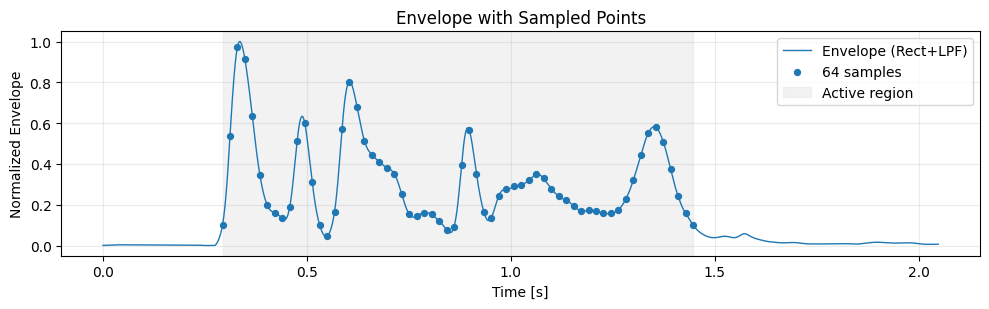

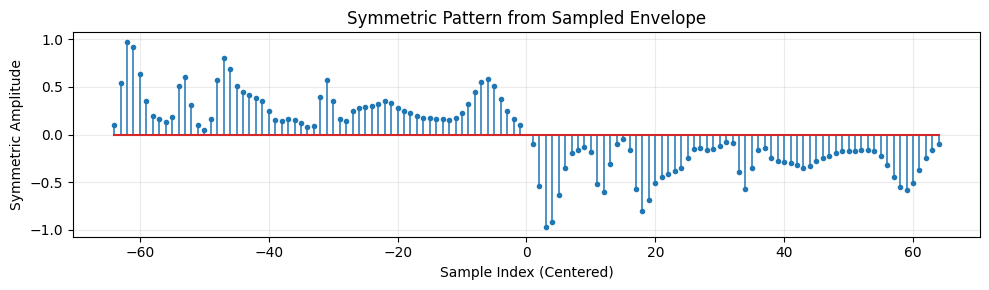

✅ Envelope sampled and pattern created (N=64).
   - Used envelope: Rect+LPF
   - Active region: 0.293s to 1.447s
🖼️  Plots saved: 'plots\3_envelope_sampling.png' and 'plots\3_symmetric_pattern.png'
----------------------------------------------------------------------------------------------------


In [4]:
# =============================================================================
# 3️. ENVELOPE SAMPLING & SYMMETRY  
# =============================================================================

print("▶️  Starting Section 3: Envelope Sampling...")

# --- 1) Choose which envelope to use ---
use_hilbert = False
env_src = env_hil_n if use_hilbert else env_lpf_n
env_name = "Hilbert (smoothed)" if use_hilbert else "Rect+LPF"
env01 = normalize_01(env_src)

# --- 2) Crop to active region ---
threshold = 0.10
active_mask = env01 >= threshold
if active_mask.any():
    k_start = int(np.argmax(active_mask))
    k_end = int(len(active_mask) - np.argmax(active_mask[::-1]) - 1)
else:
    k_start, k_end = 0, len(env01) - 1

# --- 3) Sample N points uniformly over the active region ---
idx = np.linspace(k_start, k_end, N_ENV, dtype=int)
idx = np.unique(idx)
if len(idx) < N_ENV:
    idx = np.pad(idx, (0, N_ENV - len(idx)), mode="edge")

samples = env01[idx]

# --- 4) Build a symmetric vector ---
sym_samples = np.concatenate([samples, -samples])
x_pos = np.r_[-N_ENV:0, 1:N_ENV+1]

# --- 5) Plot: Envelope with sample markers ---
fig, ax = plt.subplots(figsize=(10, 3.2))
ax.plot(t, env01, lw=1.0, label=f"Envelope ({env_name})")
ax.scatter(t[idx], samples, s=18, zorder=3, label=f"{N_ENV} samples")
ax.axvspan(t[k_start], t[k_end], color='0.9', alpha=0.5, label="Active region")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Normalized Envelope")
ax.set_title("Envelope with Sampled Points")
ax.legend(loc="upper right")
ax.grid(alpha=0.25)
fig.tight_layout()
fig.savefig(PLOTS / "3_envelope_sampling.png", dpi=200)
plt.show()

# --- 6) Plot: Symmetric vertical pattern ---
fig, ax = plt.subplots(figsize=(10, 3.0))
markerline, stemlines, baseline = ax.stem(x_pos, sym_samples)
plt.setp(stemlines, linewidth=1.1)
plt.setp(markerline, markersize=3)
ax.set_xlabel("Sample Index (Centered)")
ax.set_ylabel("Symmetric Amplitude")
ax.set_title("Symmetric Pattern from Sampled Envelope")
ax.grid(alpha=0.25)
fig.tight_layout()
fig.savefig(PLOTS / "3_symmetric_pattern.png", dpi=200)
plt.show()

print(f"✅ Envelope sampled and pattern created (N={N_ENV}).")
print(f"   - Used envelope: {env_name}")
print(f"   - Active region: {t[k_start]:.3f}s to {t[k_end]:.3f}s")
print(f"🖼️  Plots saved: '{PLOTS / '3_envelope_sampling.png'}' and '{PLOTS / '3_symmetric_pattern.png'}'")
print("-" * 100)

# 4. SPECTRAL ANALYSIS  

## Theory  

The **Discrete-Time Fourier Transform (DFT)** expresses a signal in the frequency domain:  

$$
X[k] = \sum_{n=0}^{N-1} x[n] \, e^{-j 2\pi kn / N}, \quad k=0,\dots,N-1
$$  

- Computed efficiently with the **Fast Fourier Transform (FFT)** *[lecture 3]*.  
- Frequency resolution depends on FFT length:  
$$
\Delta f = \frac{f_s}{N_{\text{FFT}}}
$$  

### Windowing  
- Truncation of $x[n]$ introduces **spectral leakage**.  
- Multiplying by a smooth window (e.g. Hann) reduces leakage but widens main lobes, reflecting the **time–frequency trade-off** *[lecture 4]* *[hands on 4]*.  
$$
w[n] = 0.5 \Big(1 - \cos\Big(\tfrac{2\pi n}{N-1}\Big)\Big), \quad 0 \leq n \leq N-1
$$  

### Magnitude Spectrum  
- FFT produces complex values; the magnitude is  
$$
|X[k]| = \sqrt{ \Re\{X[k]\}^2 + \Im\{X[k]\}^2 }
$$  
- For visualization, amplitudes are expressed in dB:  
$$
X_{\text{dB}}[k] = 20 \log_{10}\!\left(\tfrac{|X[k]|}{\max |X[k]|}\right)
$$  

## Reflection  

- Windowing mitigates leakage while sacrificing some resolution *[lecture 4]*.  
- Zero-padding refines frequency spacing without altering the true spectrum.  
- Restricting to the 0–4 kHz band is sufficient for speech, as most energy lies below this range *[lecture 1]*.  
- Removing the DC component avoids bias in low-frequency bins.  
- This analysis illustrates the direct application of Fourier theory to real signals, consistent with course demonstrations on synthetic and musical sounds *[hands on 3]*.  


▶️  Starting Section 4: Spectrum Analysis (FFT)...


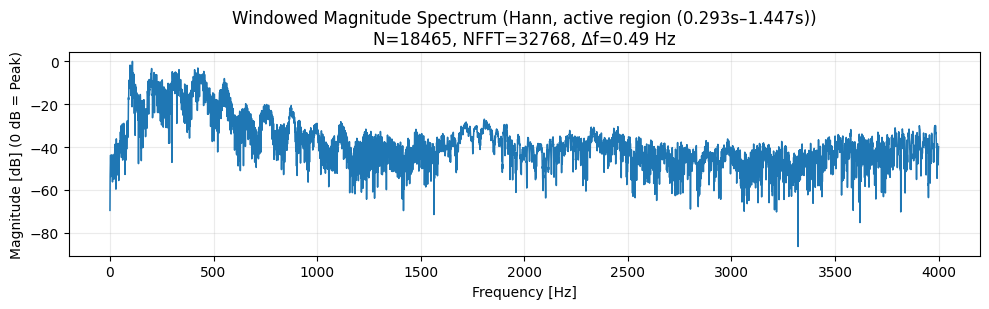

✅ FFT computed successfully.
   - Segment: active region (0.293s–1.447s) | Samples: 18465
   - NFFT=32768 | Freq. Resolution Δf=0.488 Hz | Window=hann
🖼️  Plot saved: 'plots\4_spectrum.png'
----------------------------------------------------------------------------------------------------


In [5]:
# =============================================================================
# 4️. SPECTRAL ANALYSIS 
# =============================================================================

print("▶️  Starting Section 4: Spectrum Analysis (FFT)...")

# --- 1) Select the audio segment ---
x_seg = x[k_start:k_end+1].copy()
seg_label = f"active region ({t[k_start]:.3f}s–{t[k_end]:.3f}s)"
x_seg -= np.mean(x_seg)

# --- 2) Apply window ---
N_win = len(x_seg)
win = signal.get_window(WIN_TYPE, N_win, fftbins=True)
xw = x_seg * win

# --- 3) Compute FFT ---
def next_pow2(n):
    return 1 << (n - 1).bit_length()

NFFT = next_pow2(N_win)
X = np.fft.rfft(xw, n=NFFT)
f = np.fft.rfftfreq(NFFT, d=1/fs)

# --- 4) Convert magnitude to dB ---
mag = np.abs(X)
mag_db = 20 * np.log10(mag / (mag.max() + 1e-12) + 1e-12)

# --- 5) Plot spectrum up to FMAX_HZ ---
band_mask = f <= FMAX_HZ
df = f[1] - f[0] if len(f) > 1 else float('nan')

fig, ax = plt.subplots(figsize=(10, 3.2))
ax.plot(f[band_mask], mag_db[band_mask], lw=1.1)
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Magnitude [dB] (0 dB = Peak)")
ax.set_title(
    f"Windowed Magnitude Spectrum ({WIN_TYPE.capitalize()}, {seg_label})\n"
    f"N={N_win}, NFFT={NFFT}, Δf={df:.2f} Hz"
)
ax.grid(alpha=0.25)
fig.tight_layout()
fig.savefig(PLOTS / "4_spectrum.png", dpi=200)
plt.show()

print("✅ FFT computed successfully.")
print(f"   - Segment: {seg_label} | Samples: {N_win}")
print(f"   - NFFT={NFFT} | Freq. Resolution Δf={df:.3f} Hz | Window={WIN_TYPE}")
print(f"🖼️  Plot saved: '{PLOTS / '4_spectrum.png'}'")
print("-" * 100)

# 5. SPECTRAL BAND AGGREGATION  

## Theory  

Instead of analyzing the full FFT, energy can be **aggregated into frequency bands** for a compact representation:  

1. **Band partitioning**  
   - Divide $[0, F_{\max}]$ into $B$ bands:  
   $$
   f_{b,0} = \tfrac{(b-1)}{B}F_{\max}, \quad f_{b,1} = \tfrac{b}{B}F_{\max}
   $$  
   - Band centers:  
   $$
   c_b = \tfrac{1}{2}(f_{b,0} + f_{b,1})
   $$  

2. **RMS magnitude per band**  
   - Spectrum magnitude: $|X(f)|$  
   - Compute RMS magnitude within band:  
   $$
   M_b = \sqrt{\tfrac{1}{|I_b|}\sum_{f \in I_b} |X(f)|^2}
   $$  
   where $I_b$ are the FFT bins of band $b$ *[lecture 4]*.  

3. **Logarithmic scaling (same reference as the continuous spectrum)**  
   - Use the same reference as for the continuous spectrum (e.g. $M_{\text{ref}} = \max_{f \in [0,F_{\max}]} |X(f)|$):  
   $$
   M_b^{\text{dB}} = 20 \log_{10}\!\left(\tfrac{M_b}{M_{\text{ref}}}\right)
   $$  
   This ensures that the band bars are directly comparable to the continuous magnitude spectrum.  

This parallels **filterbank representations** such as MFCCs or cochlear models used in speech analysis *[lecture 3]*.  

## Reflection  

- Band aggregation compresses the spectral detail into a robust, lower-dimensional representation.  
- It smooths out fine variations due to noise or windowing, while retaining essential spectral shape.  
- With $B=40$, the resolution approximates **critical bands** relevant to human auditory perception *[lecture 3]*.  
- The resulting band profile in dB uses the **same reference as the continuous spectrum**, making the overlaid bars visually and numerically comparable to the line plot, while still serving as a compact **feature vector** for visualization and sound-art mapping.  

▶️  Starting Section 5: Frequency Band Aggregation...


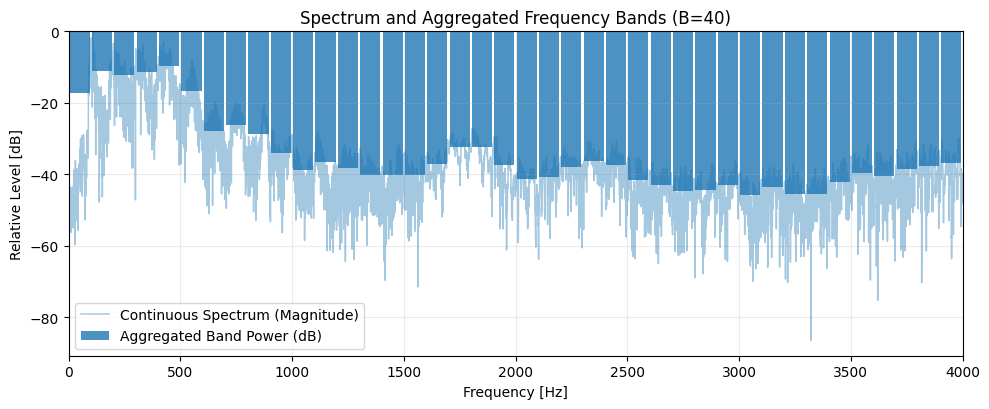

✅ Bands computed: B=40, from 0.0 Hz to 4000.0 Hz.
🖼️  Plot saved: 'plots\5_spectrum_and_bands.png'
----------------------------------------------------------------------------------------------------


In [6]:
# =============================================================================
# 5. SPECTRAL BAND AGGREGATION  
# =============================================================================

print("▶️  Starting Section 5: Frequency Band Aggregation...")

# --- 1) Define linear frequency bands ---
edges = np.linspace(0.0, FMAX_HZ, N_BANDS + 1)
centers = 0.5 * (edges[:-1] + edges[1:])

# --- 2) Aggregate mean power per band ---
f_sel = f[band_mask]
X_sel = X[band_mask]
power = np.abs(X_sel) ** 2
band_vals_power = np.zeros(N_BANDS)

for b in range(N_BANDS):
    f0, f1 = edges[b], edges[b+1]
    in_band_mask = (f_sel >= f0) & (f_sel < f1)
    if b == N_BANDS - 1:
        in_band_mask = (f_sel >= f0) & (f_sel <= f1)
        
    if np.any(in_band_mask):
        band_vals_power[b] = np.mean(power[in_band_mask])

# --- 3) Convert band power to dB ---
EPS = 1e-12
mag_ref = np.max(np.abs(X[band_mask])) + EPS 
band_vals_mag = np.sqrt(band_vals_power)  
band_vals_db = 20 * np.log10(band_vals_mag / mag_ref + EPS)

# --- 4) Plot spectrum with overlaid band bars ---
fig, ax = plt.subplots(figsize=(10, 4.2))
ax.plot(f[band_mask], mag_db[band_mask], lw=1.1, label="Continuous Spectrum (Magnitude)", alpha=0.4)
ax.bar(centers, band_vals_db, width=(edges[1] - edges[0]) * 0.9, alpha=0.8, label="Aggregated Band Power (dB)")
ax.set_xlim(0, FMAX_HZ)
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Relative Level [dB]")
ax.set_title(f"Spectrum and Aggregated Frequency Bands (B={N_BANDS})")
ax.grid(alpha=0.25)
ax.legend()
fig.tight_layout()
fig.savefig(PLOTS / "5_spectrum_and_bands.png", dpi=200)
plt.show()

print(f"✅ Bands computed: B={N_BANDS}, from {edges[0]:.1f} Hz to {edges[-1]:.1f} Hz.")
print(f"🖼️  Plot saved: '{PLOTS / '5_spectrum_and_bands.png'}'")
print("-" * 100)

# 6. ARTISTIC VISUALIZATION  

## Theory  

Two complementary artistic views are generated from the speech signal:  

1. **Envelope-based pattern**  
   - The normalized envelope is divided into $N_{\text{bars}}$ bins.  
   - The mean amplitude in each bin defines a vertical symmetric bar.  
   - The result is a **waveform-like structure**, rendered with color mapping.  

2. **Spectrum-based pattern**  
   - The magnitude spectrum is aggregated into $B$ frequency bands.  
   - Each band energy is converted into decibels relative to the peak.  
   - Bars start from **0 dB upwards**, with horizontal stripes to emphasize the layered texture.  

This approach translates both **temporal dynamics** (via the envelope) and **spectral balance** (via band energies) into geometric and colorful figures.  

## Reflection  

- The envelope pattern highlights rhythm and phrasing through symmetric vertical bars.  
- The spectrum pattern transforms frequency content into an upward structure with decorative layers.  
- The number of bars controls detail: more bars give finer resolution, fewer bars give smoother visuals.  
- Both methods remain firmly grounded in DSP concepts (envelope extraction, band aggregation, decibel scaling) while producing **abstract sound art**.  
- Combining time and frequency views emphasizes two complementary aspects of speech in a unified artistic representation.  


▶️  Starting Section 6: Artistic Visualization...


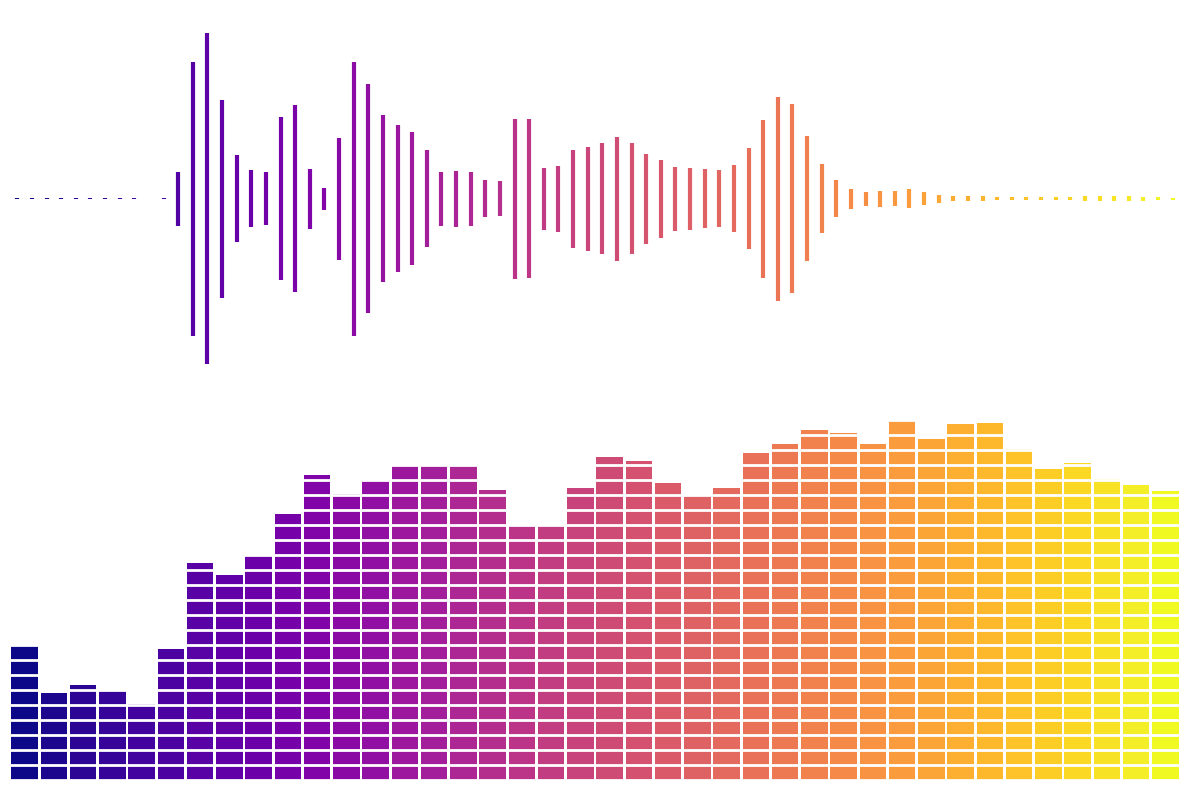

🎨 Combined artistic figure created: envelope (top) + spectrum (bottom).
🖼️  Plot saved: 'plots\6_artistic_combo.png'
----------------------------------------------------------------------------------------------------


In [7]:
# =============================================================================
# 6. ARTISTIC VISUALIZATION
# =============================================================================

print("▶️  Starting Section 6: Artistic Visualization...")

# --- Parameters ---
N_BARS_ART = 80                 # number of bars for envelope visualization
FLOOR_DB   = -80.0              # minimum dB floor for artistic spectrum
FMAX_ART_HZ = FMAX_HZ           # maximum frequency displayed for spectrum

# --- 1) Envelope binning ---
bin_edges = np.linspace(0, len(env01), N_BARS_ART + 1, dtype=int)
bar_times, bar_heights = [], []

for b in range(N_BARS_ART):
    i0, i1 = bin_edges[b], bin_edges[b+1]
    if i1 > i0:
        bar_heights.append(np.mean(env01[i0:i1]))
        bar_times.append(0.5 * (t[i0] + t[i1-1]))

bar_times = np.array(bar_times)
bar_heights = np.array(bar_heights)

# --- 2) Colormap based on time ---
cmap_time = plt.cm.plasma
norm_time = mpl.colors.Normalize(vmin=bar_times.min(), vmax=bar_times.max())
colors_time = cmap_time(norm_time(bar_times))

# --- 3) Spectrum preparation (convert band levels to upward bars) ---
band_vals_db_clipped = np.clip(band_vals_db, FLOOR_DB, 0.0)
heights_db = 0.0 - band_vals_db_clipped
bin_spacing = (centers[1] - centers[0]) if len(centers) > 1 else FMAX_ART_HZ

cmap_freq = plt.cm.plasma
norm_freq = mpl.colors.Normalize(vmin=centers.min(), vmax=centers.max())
colors_freq = cmap_freq(norm_freq(centers))

# --- 4) Combined artistic figure ---
fig, axs = plt.subplots(
    2, 1, figsize=(12, 8),
    gridspec_kw={"height_ratios": [1, 1]}
)

# (Top) Artistic envelope visualization
for tt, hh, col in zip(bar_times, bar_heights, colors_time):
    axs[0].vlines(tt, -hh, hh, color=col, lw=3)
axs[0].set_ylim(-1.05, 1.05)
axs[0].set_xlim(t[0], t[-1])
axs[0].axis("off")

# (Bottom) Artistic spectrum visualization
for fc, h, col in zip(centers, heights_db, colors_freq):
    axs[1].bar(fc, h, bottom=0, width=bin_spacing*0.9,
               color=col, edgecolor='none', align='center')

# Add decorative horizontal white stripes
hline = np.linspace(0, heights_db.max(), 25)
axs[1].hlines(hline, -500, centers[-1] + 500, colors='white', lw=2.0)

axs[1].set_xlim(0, FMAX_ART_HZ)
axs[1].set_ylim(0, heights_db.max()*1.05)
axs[1].axis("off")

plt.tight_layout()
fig.savefig(PLOTS / "6_artistic_combo.png", dpi=300)
plt.show()

print("🎨 Combined artistic figure created: envelope (top) + spectrum (bottom).")
print(f"🖼️  Plot saved: '{PLOTS / '6_artistic_combo.png'}'")
print("-" * 100)


# 7. FINAL ASSEMBLY & REFLECTION  

All components now come together:  
- **Envelope features** → sampled values and symmetric time-domain patterns.  
- **Spectral features** → FFT spectra and band-aggregated energies.  
- **Artistic waveform** → vertical bars reflecting rhythmic envelope variation.  

Together, these representations highlight two complementary dimensions of speech:  
- **Temporal fluctuations** (rhythm, phrasing, dynamics).  
- **Spectral distribution** (timbre, harmonic structure, frequency balance).  

### Critical Insights  

- Parameter choices ($N$ samples, $B$ bands, window type, cutoff $f_c$) influence both analysis and **visual aesthetics**.  
- **Hilbert vs. Rect+LPF** envelopes yield distinct visual outcomes while remaining theoretically valid.  
- **Windowing and FFT resolution** illustrate the trade-off between accuracy and smoothness.  
- Restricting to **0–4 kHz** is appropriate for speech but adaptable for other signals.  

This final stage shows how **signal processing principles** can be reframed into **aesthetic creation**, turning rigorous DSP into visually meaningful art.  